In [1]:
import torch
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from chirho.robust.internals.utils import ParamDict

pyro.settings.set(module_local_params=True)
sns.set_style("white")
pyro.set_rng_seed(321)  # for reproducibility

In [2]:
class ToyNormal(pyro.nn.PyroModule):
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=sd),
        )


class ToyNormalKnownSD(pyro.nn.PyroModule):
    def __init__(self, sd_true):
        super().__init__()
        self.sd_true = sd_true
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=self.sd_true),
        )

class GroundTruthToyNormal(pyro.nn.PyroModule):
    def __init__(self, mu_true, sd_true):
        super().__init__()
        self.mu_true = mu_true
        self.sd_true = sd_true
    def forward(self):
        return pyro.sample(
            "Y",
            dist.Normal(self.mu_true, scale=self.sd_true),
        )

In [3]:
normal_pdf = lambda x, mu, sd: torch.exp(-0.5 * ((x - mu) / sd) ** 2) / (sd * math.sqrt(2.0 * math.pi))
normal_pdf_partial_sd = torch.func.grad(normal_pdf, argnums=2)


def fisher_eif_analytic(Y, mu, sd, known_sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    if known_sd:
        return torch.zeros(Y.shape[0])
    else:
        sd_torch = torch.tensor(sd, requires_grad=True)
        z_monte = sd * torch.randn(10000) + mu
        grad_functional = 2 * torch.tensor([normal_pdf_partial_sd(z, mu, sd_torch) for z in z_monte]).mean()
        inverse_fisher = sd ** 2 / 2
        score = ((Y - mu) ** 2) / (sd ** 3) - 1/sd
    return grad_functional * inverse_fisher * score


def kennedy_if_analytic(Y, mu, sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    pdf_at_y = normal_pdf(Y, mu, sd)
    z_monte = sd * torch.randn(100000)
    expected_density = torch.tensor([normal_pdf(z, mu, sd) for z in z_monte]).mean()
    return 2 * (pdf_at_y - expected_density)

# Analytic Influence Function & Efficient Influence Function

In [4]:
N_pts = 500
mu_true = 0.0
sd_true = 1.0
true_model = GroundTruthToyNormal(mu_true, sd_true)
D_pts = Predictive(true_model, num_samples=N_pts, return_sites=["Y"])()
Y_pts = D_pts["Y"]
Y_pts = torch.sort(Y_pts).values

fisher_pointwise = fisher_eif_analytic(Y_pts, mu_true, sd_true, False)
kennedy_pointwise = kennedy_if_analytic(Y_pts, mu_true, sd_true)
tangent_fn_pointwise = kennedy_pointwise - fisher_pointwise

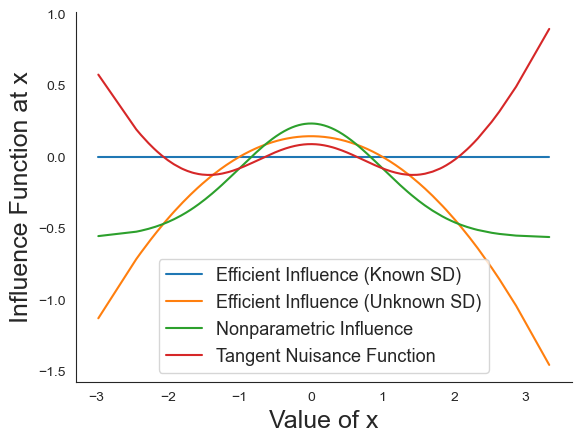

In [8]:

plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label="Efficient Influence (Known SD)")
plt.plot(Y_pts, fisher_pointwise, label="Efficient Influence (Unknown SD)")
plt.plot(Y_pts, kennedy_pointwise, label="Nonparametric Influence")
plt.plot(Y_pts, tangent_fn_pointwise, label="Tangent Nuisance Function")
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.savefig("figures/toy_normal_influence_functions.pdf")

In [9]:
# This should be close to zero since the tangent nuisance function is orthogonal to the efficient influence function
fisher_pointwise.dot(tangent_fn_pointwise) / N_pts

tensor(0.0004)

# Compare Analytic w/ Automated Influnce Functions

In [10]:
import functools
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

In [11]:
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )
            
class ExpectedDensity(torch.nn.Module):
    def __init__(self, model, *, num_monte_carlo: int = 10000):
        super().__init__()
        self.model = model
        self.log_marginal_prob = BatchedNMCLogMarginalLikelihood(model, num_samples=1)
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", self.num_monte_carlo):
            points = PredictiveFunctional(self.model)(*args, **kwargs)

        log_marginal_prob_at_points = self.log_marginal_prob(points, *args, **kwargs)
        return torch.exp(
            torch.logsumexp(log_marginal_prob_at_points, dim=0)
            - math.log(self.num_monte_carlo)
        )

In [17]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
    "sd": torch.tensor(sd_true, requires_grad=True)
}

model = ToyNormal()
guide = MLEGuide(theta_true)

monte_eif = influence_fn(
    functional, {'Y': Y_pts}, num_samples_outer=50000, num_samples_inner=1
)(PredictiveModel(model, guide))()

## Uknown Mean, Unknown SD

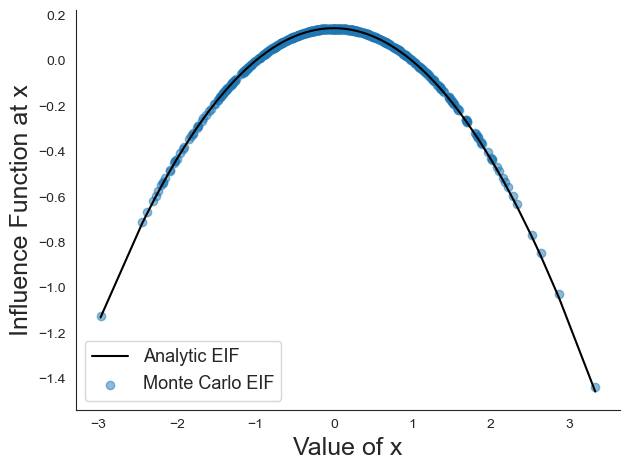

In [18]:
plt.plot(Y_pts, fisher_pointwise, label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_unknown_var.pdf")

## Uknown Mean, Known SD

In [19]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
}

model = ToyNormalKnownSD(sd_true)
guide = MLEGuide(theta_true)

monte_eif = influence_fn(
    functional, {'Y': Y_pts}, num_samples_outer=50000, num_samples_inner=1
)(PredictiveModel(model, guide))()

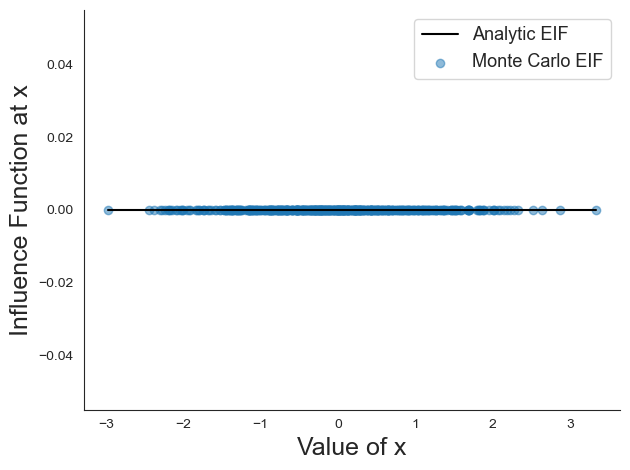

In [20]:
plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of x', fontsize=18)
plt.ylabel('Influence Function at x', fontsize=18)
plt.legend(fontsize=13)
sns.despine()
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_known_var.pdf")

# Finite-Difference Smoothed Gateaux Approach

In [14]:
import sys
sys.path.append("../scripts/")
from fd_influence_approx import (
    compute_fd_correction_sqd_mvn_mc,
    compute_fd_correction_sqd_mvn_quad
)

In [15]:
theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True).unsqueeze(0), 
    "scale_tril": torch.tensor(sd_true, requires_grad=True).unsqueeze(0)
}


fd_quad_kwargs = {
    "lambdas": [.05, .01, .005],
    "epss": [.05, .01, .005],
    "num_samples_scaling": 10,
    "seed": 0,
}

fd_quad_eif_results = compute_fd_correction_sqd_mvn_quad(
    theta_hat=theta_true,
    test_data={'x': Y_pts.unsqueeze(-1)},
    **fd_quad_kwargs
)

/Users/raj/Desktop/causal_pyro/docs/examples/robust_paper/finite_difference_eif/distributions.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  self.cov = scale_tril @ scale_tril.T


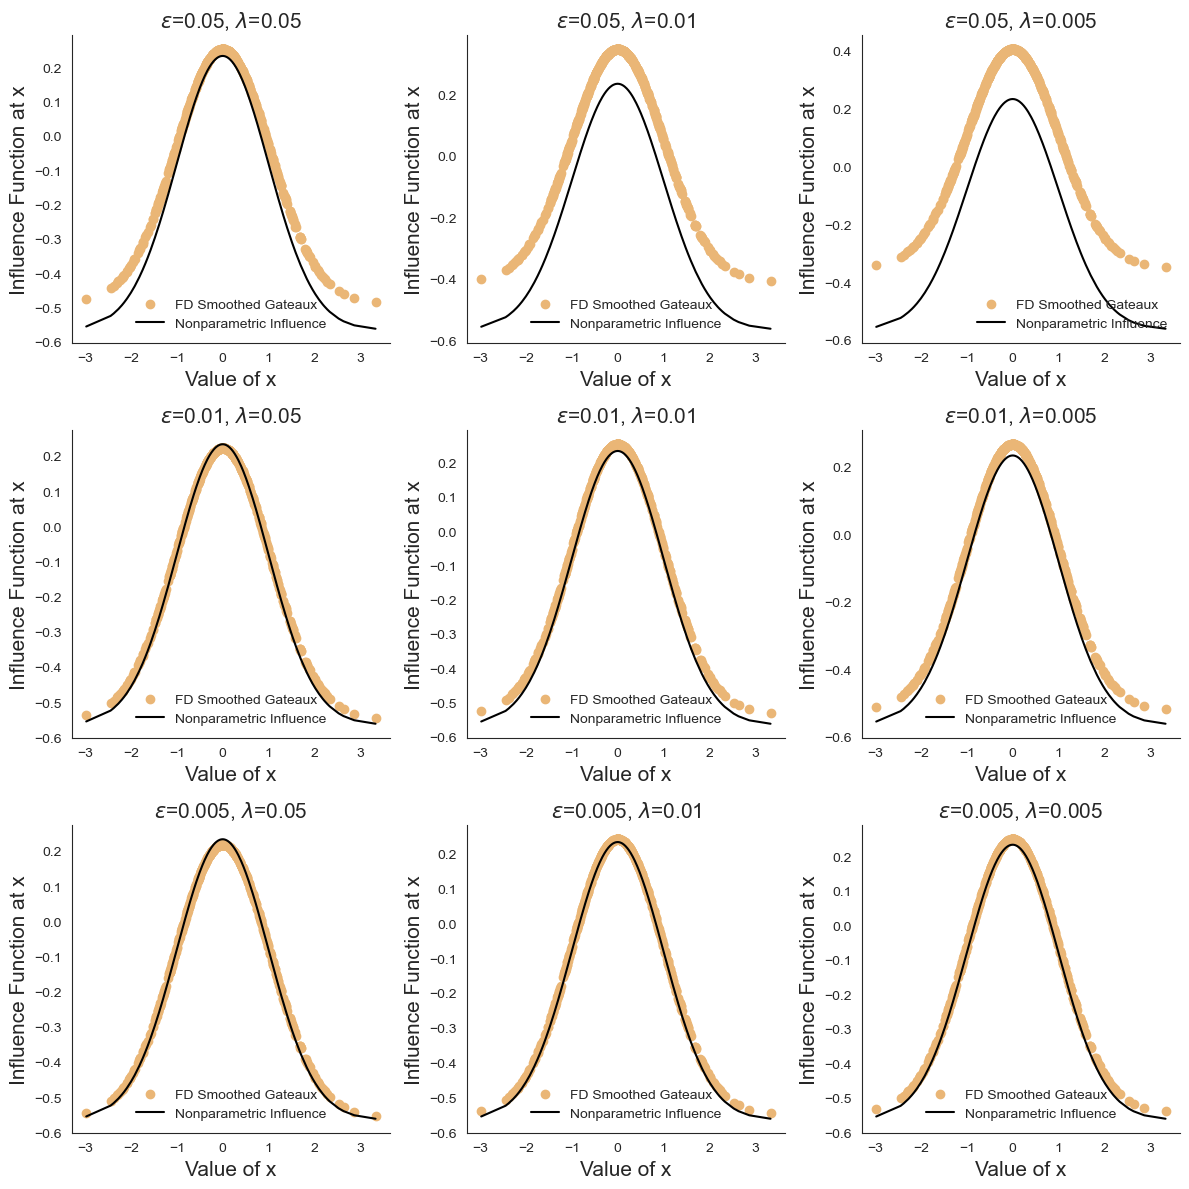

In [17]:
# Plot 3 x 3 grid of results
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for iter, result in enumerate(fd_quad_eif_results):
        i = iter // 3
        j = iter % 3
        epsilon = fd_quad_kwargs["epss"][i]
        lam = fd_quad_kwargs["lambdas"][j]
        axes[i, j].scatter(Y_pts, result['pointwise'], label='FD Smoothed Gateaux', color='#eab676')
        axes[i, j].plot(Y_pts, kennedy_pointwise, label='Nonparametric Influence', color='black')
        axes[i, j].set_xlabel('Value of x', fontsize=15)
        axes[i, j].set_ylabel('Influence Function at x', fontsize=15)
        axes[i, j].set_title(f"$\epsilon$={epsilon}, $\lambda$={lam}", fontsize=15)
        axes[i, j].legend(frameon=False)
        sns.despine()

plt.tight_layout()
plt.savefig("./figures/expected_density_gateaux_grid.png")

# Runtime vs. Quality

In [21]:
def median_rel_error(x, y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return torch.median(torch.abs(x - y) / torch.abs(y))

fd_quad_rel_mae = [median_rel_error(result['pointwise'], kennedy_pointwise) for result in fd_quad_eif_results]
fd_quad_time = [result['wall_time'] for result in fd_quad_eif_results]

NameError: name 'fd_quad_eif_results' is not defined

In [22]:
monte_eif_size = []
monte_eif_errors = []
monte_eif_runtimes = []
for n_monte in [10, 100, 1000, 10000, 100000]:
    start = time.time()
    functional = functools.partial(ExpectedDensity, num_monte_carlo=n_monte)
    theta_true = {
        "mu": torch.tensor(mu_true, requires_grad=True), 
        "sd": torch.tensor(sd_true, requires_grad=True)
    }

    model = ToyNormal()
    guide = MLEGuide(theta_true)
    monte_eif = influence_fn(
        functional, {'Y': Y_pts}, num_samples_outer=n_monte, num_samples_inner=1
    )(PredictiveModel(model, guide))()
    end = time.time()
    monte_eif_runtimes.append(end - start)
    monte_eif_errors.append(median_rel_error(monte_eif, fisher_pointwise))
    monte_eif_size.append(n_monte)


/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_53328/3498049407.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_53328/3498049407.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


NameError: name 'fd_quad_time' is not defined

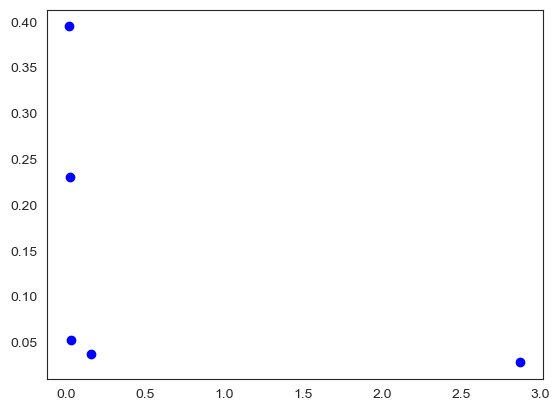

In [23]:
# plt.scatter(monte_eif_runtimes, monte_eif_errors, label='Monte Carlo EIF', color='blue')
# plt.scatter(fd_quad_time, fd_quad_rel_mae, label='FD Smoothed Gateaux', color='#eab676')
# plt.xlabel('Wall Time (s)', fontsize=18)
# plt.ylabel('Median Relative Error', fontsize=18)
# # plt.xscale('log')
# # plt.yscale('log')
# plt.legend(fontsize=12)
# sns.despine()
# plt.tight_layout()

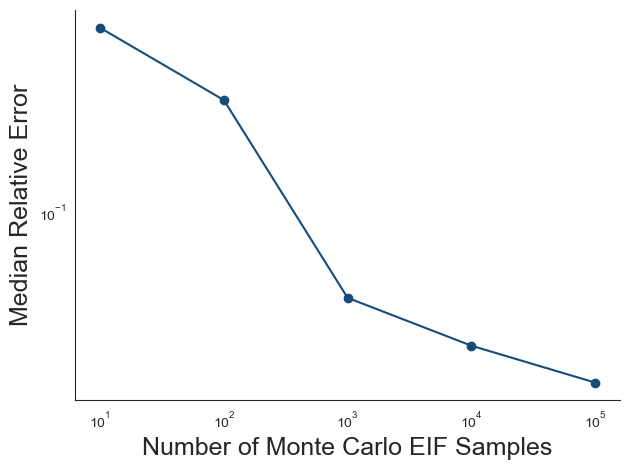

In [25]:
plt.plot(
    monte_eif_size, 
    monte_eif_errors, 
    label='Monte Carlo EIF', 
    color='#154c79',
    marker='o'
)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Median Relative Error', fontsize=18)
plt.xlabel('Number of Monte Carlo EIF Samples', fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig("./figures/monte_carlo_eif_samples_vs_error_expected_density.png")

In [42]:
base_dist = dist.Normal(torch.tensor(0.0), torch.tensor(1.0))
dist_y = dist.TransformedDistribution(base_dist, [pyro.distributions.transforms.ExpTransform()])

In [43]:
dist_y.

AttributeError: 'TransformedDistribution' object has no attribute 'params'

In [120]:
# class NormalizingFlowModel(pyro.nn.PyroModule):
#     def __init__(self):
#         self.base_dist = dist.Normal(0, 1)
#         self.exp_transform = dist.transforms.ExpTransform()

#     def forward():
#         return pyro.sample("Y", dist.TransformedDistribution(self.base_dist, [self.exp_transform]))

base_dist = dist.Normal(torch.zeros(10), torch.ones(10))


class NormalizingFlowLikelihood(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.base_dist = torch.distributions.normal.Normal(torch.tensor([0]), torch.tensor([1]))
        self.base_dist = dist.Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([1])
        self.arn = pyro.nn.AutoRegressiveNN(1, [40], param_dims=[16]*3)
        self.transform = dist.transforms.NeuralAutoregressive(self.arn, hidden_units=16)
        # self.transform = dist.transforms.ExpTransform()

    def forward(self, x):
        return dist.TransformedDistribution(self.base_dist, [self.transform]).log_prob(x)

In [121]:
NormalizingFlowLikelihood()(torch.tensor([[1]]))

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


NotImplementedError: 

: 